In [40]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

pd.options.mode.chained_assignment = None

In [41]:
file_name = 'pre_processado_completo.csv'

df = pd.read_csv(file_name, header=0, error_bad_lines=False, warn_bad_lines=False)

In [42]:
df.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The...,29.883056,-97.941111,1949-10-10
1,chester (uk/england),NaN,gb,circle,0.333333,Green/Orange circular disc over Chester&#44 England,53.200000,-2.916667,1955-10-10
2,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took ...,28.978333,-96.645833,1956-10-10
3,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/attack aircraft on a solo night exercise&#44 I was at 50&#44000&#39 in a ...,21.418056,-157.803611,1960-10-10
4,bristol,tn,us,sphere,5.000000,My father is now 89 my brother 52 the girl with us now 51 myself 49 and the other fellow which worked with my father...,36.595000,-82.188889,1961-10-10


In [64]:
# limita o df aos USA

df_us = df.loc[df['country'] == 'us']
df_us.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The...,29.883056,-97.941111,1949-10-10
2,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took ...,28.978333,-96.645833,1956-10-10
3,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/attack aircraft on a solo night exercise&#44 I was at 50&#44000&#39 in a ...,21.418056,-157.803611,1960-10-10
4,bristol,tn,us,sphere,5.000000,My father is now 89 my brother 52 the girl with us now 51 myself 49 and the other fellow which worked with my father...,36.595000,-82.188889,1961-10-10
6,norwalk,ct,us,disk,20.000000,A bright orange color changing to reddish color disk/saucer was observed hovering above power transmission lines.,41.117500,-73.408333,1965-10-10


In [44]:
# define um array com as latitudes e longitudes

lat_lon = np.array(df_us[['longitude', 'latitude']]).astype(float)
print(len(lat_lon))
print(lat_lon)

75982
[[ -97.9411111   29.8830556]
 [ -96.6458333   28.9783333]
 [-157.8036111   21.4180556]
 ...
 [ -78.427222    39.078889 ]
 [ -74.163755    40.858433 ]
 [ -77.710548    34.367594 ]]


In [45]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

states = list(df_us['state'])
pesos = [states.count(s) for s in states]

In [65]:
scaler = MinMaxScaler()

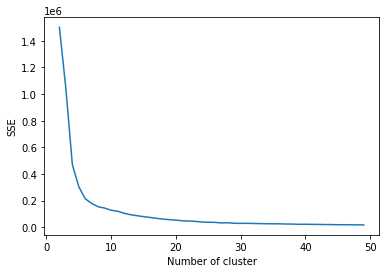

In [66]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Visto que o range para o Elbow Criteria foi grande, o número adequado de clusters está entre 10 e 22
#### A soma dos erros quadráticos não apresenta decaimento significante a partir desses valores, logo o gasto computacional para k_clusters maiores não se torna viável

### Para definir o melhor valor nesse range, foi utilizado o Coeficiente de Silhouette
#### quanto maior o coeficiente, menor a distância intracluster e maior a distância intercluster

In [ ]:
# aplica o coeficiente de silhouette

for k in range(5, 22):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

Para n_clusters=5, o coeficiente de  Silhouette 0.47457705776513726
Para n_clusters=6, o coeficiente de  Silhouette 0.5242185674138998
Para n_clusters=7, o coeficiente de  Silhouette 0.4908266560501421
Para n_clusters=8, o coeficiente de  Silhouette 0.444166666077026
Para n_clusters=9, o coeficiente de  Silhouette 0.45274606804374096
Para n_clusters=10, o coeficiente de  Silhouette 0.45951094716128316


### De acordo com o Coeficiente de Silhouette o número adequado de clusters é em torno de 12

In [52]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=12, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.24487947, 0.28370461],
       [0.24890894, 0.26809065],
       [0.05865404, 0.13761325],
       ...,
       [0.30558497, 0.44240889],
       [0.31884813, 0.47312076],
       [0.30781446, 0.36110003]])

In [53]:
centers = kmeans.cluster_centers_
centers

array([[0.31391828, 0.47578275],
       [0.17249245, 0.41906327],
       [0.25496993, 0.30497582],
       [0.1713465 , 0.58084917],
       [0.18565611, 0.35239039],
       [0.28100476, 0.44169713],
       [0.18318096, 0.46514836],
       [0.08757115, 0.83231765],
       [0.0601231 , 0.13097526],
       [0.29410574, 0.24209803],
       [0.29002672, 0.37522858],
       [0.28516295, 0.50801377]])

In [54]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

75982


array([ 2.,  2.,  8., ...,  5.,  0., 10.])

Text(0, 0.5, 'Longitude')

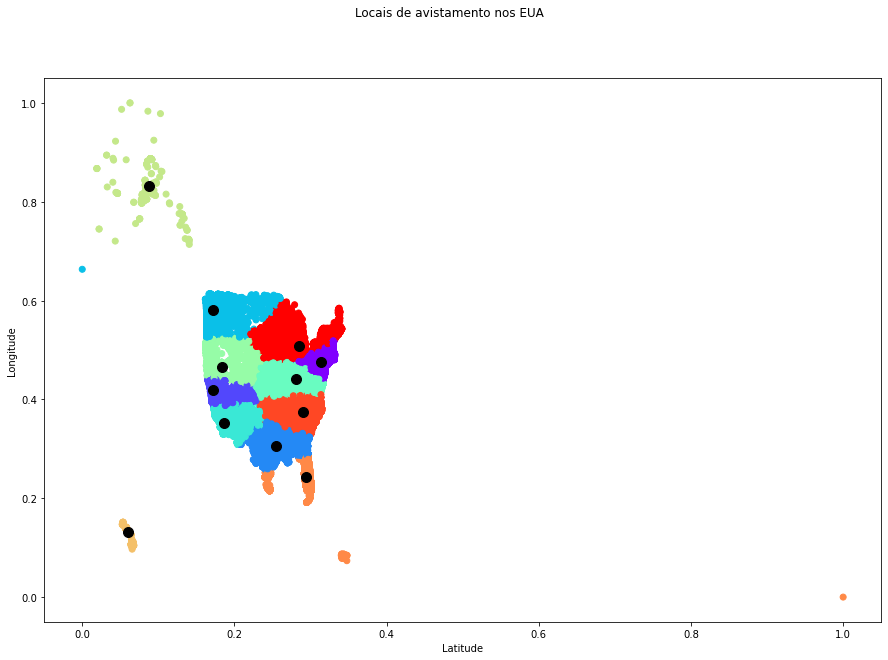

In [55]:
fig , ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=locations, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento nos EUA')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

Text(0, 0.5, 'Longitude')

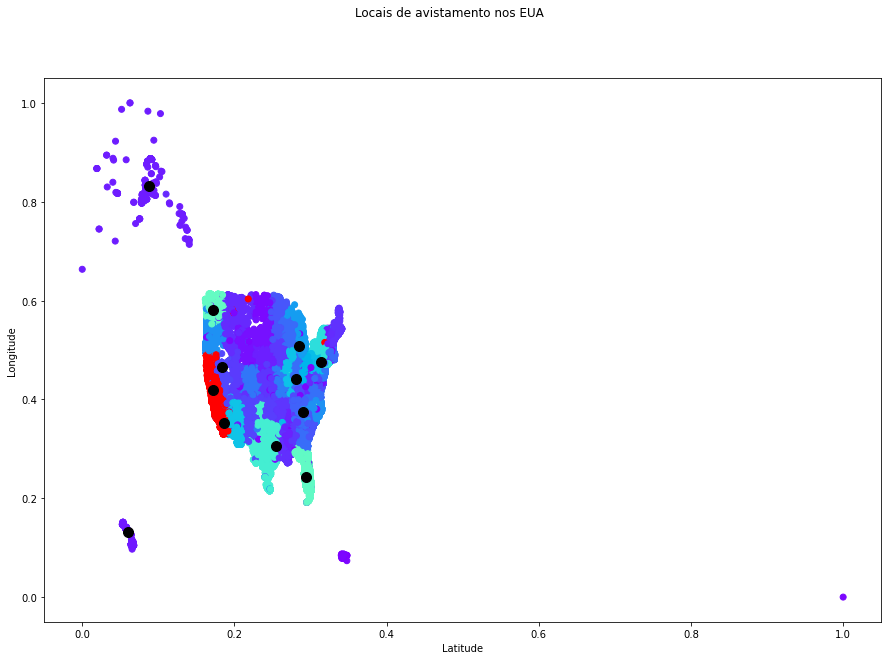

In [56]:
fig , ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento nos EUA')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [57]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [58]:
centers_notscaled = scaler.inverse_transform(centers)
centers_notscaled = centers_notscaled.tolist()

for i in range(len(centers_notscaled)):
    centers_notscaled[i][0], centers_notscaled[i][1] = centers_notscaled[i][1], centers_notscaled[i][0]

centers_notscaled = [tuple(center) for center in centers_notscaled]
centers_notscaled

[(41.0126768829856, -75.74846221690707),
 (37.72616921221512, -121.21004785614846),
 (31.115577780486017, -94.69751673551144),
 (47.10056138195648, -121.57841613042339),
 (33.86292943665142, -116.97856616361544),
 (39.03764731348878, -86.32857341973303),
 (40.39648636404484, -117.77421011849613),
 (61.671448530742914, -148.50815172723046),
 (21.03342902681564, -157.3313769340782),
 (27.472237645548987, -82.11724145725714),
 (35.1862469863651, -83.4284482180328),
 (42.88024541019158, -84.99191572760274)]

In [59]:
address = [reverse(loc) for loc in centers_notscaled]

In [60]:
centers_states = []
for i in range(len(centers)):
    try:
        centers_states.append(address[i].raw['address']['state'])
    except:
        centers_states.append('NULL')
centers_states

['Pennsylvania',
 'California',
 'Texas',
 'Washington',
 'California',
 'Indiana',
 'Nevada',
 'Alaska',
 'NULL',
 'Florida',
 'North Carolina',
 'Michigan']

In [61]:
locations = list(locations)
locations = [int(item) for item in locations]
centers_states_all = [centers_states[loc] for loc in locations]
centers_states_all

['Texas',
 'Texas',
 'NULL',
 'North Carolina',
 'Pennsylvania',
 'North Carolina',
 'Texas',
 'California',
 'North Carolina',
 'Pennsylvania',
 'Indiana',
 'North Carolina',
 'North Carolina',
 'Michigan',
 'Pennsylvania',
 'Pennsylvania',
 'Indiana',
 'North Carolina',
 'Washington',
 'Texas',
 'Indiana',
 'Pennsylvania',
 'Pennsylvania',
 'California',
 'Nevada',
 'Texas',
 'Texas',
 'Pennsylvania',
 'Texas',
 'Michigan',
 'Pennsylvania',
 'Michigan',
 'Michigan',
 'Nevada',
 'Washington',
 'California',
 'Washington',
 'Texas',
 'North Carolina',
 'Pennsylvania',
 'Texas',
 'Texas',
 'North Carolina',
 'Texas',
 'Indiana',
 'North Carolina',
 'Pennsylvania',
 'North Carolina',
 'Michigan',
 'California',
 'Indiana',
 'North Carolina',
 'Indiana',
 'Indiana',
 'California',
 'Texas',
 'Michigan',
 'California',
 'California',
 'Michigan',
 'California',
 'California',
 'Washington',
 'North Carolina',
 'North Carolina',
 'California',
 'Indiana',
 'Texas',
 'California',
 'Washingt

In [62]:
pd.set_option("max_colwidth", 120)
df_us['pesos'] = pesos
df_us['k-states'] = centers_states_all
df_us['k-centers'] = locations
df_us[['state', 'pesos', 'k-states', 'k-centers']].head(15)

,state,pesos,k-states,k-centers
0,tx,3969,Texas,2
2,tx,3969,Texas,2
3,hi,359,NULL,8
4,tn,1294,North Carolina,10
6,ct,1049,Pennsylvania,0
7,al,747,North Carolina,10
8,fl,4512,Texas,2
9,ca,10284,California,4
10,nc,1986,North Carolina,10
11,ny,3461,Pennsylvania,0
